In [1]:
import torch
import logging

from utils.test_utils import HierarchicalDict
from utils.dataloader import load_dataset_from_folder
from models.model_utils import build_model
from utils.eval import get_ood_scores
from utils.score_func import get_ood_scores

import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import os

In [4]:
def show_images(dataset_raw):
    idx = [img_path.split('/')[-1].split('.')[0] for img_path, _ in dataset_raw.imgs]
    fig, axes = plt.subplots(figsize=(15, 3), nrows=2, ncols=10, facecolor="white")
    axes = axes.flat
    for ax, (image, label), id in zip(axes, dataset_raw, idx):
        ax.imshow(np.transpose(image, (1, 2, 0)))  # You can set the colormap (cmap) as needed
        ax.axis('off') 
        ax.set_title(id)
    plt.show()

def cal_conf_ood_scores(model, dataset, dataloader, folder_path, filename, args, device='cpu'):

    # if os.path.exists(folder_path+filename):
    #     return
    
    model.eval()
    
    # Calculate confidence scores, model predictions and OoD scores.
    #
    # Feed corrupted dataset into the CNN model -> confidence score (E_s)
    #                                          -> predicted label (E_ae)
    # Feed corrupted dataset into the OoD detectors -> ood score (E_ood)
    # Record outcomes: [idx, confidence score, ood score, predicted label]
    
    idx = [img_path.split('/')[-1].split('.')[0] for img_path, _ in dataset.imgs]
    conf_scores = torch.empty(0, dtype=torch.float32).to(device)
    pred_labels = torch.empty(0, dtype=torch.int8).to(device)
    true_labels = torch.empty(0, dtype=torch.int8)
    outputs = torch.empty(0, dtype=torch.float32).to(device)

    with torch.no_grad():
        for X, y in dataloader:

            output = model(X.to(device))
            conf, y_pred = torch.max(torch.nn.Softmax(dim=1)(output), dim=1) # -> confidence score (E_s)
                                                                            # -> predicted label (E_ae)
            conf_scores = torch.concat((conf_scores, conf))
            pred_labels = torch.concat((pred_labels, y_pred))
            true_labels = torch.concat((true_labels, y))
            outputs = torch.concat((outputs, output))

    conf_scores = conf_scores.cpu()
    pred_labels = pred_labels.cpu()
    outputs = outputs.cpu()

    ood_scores_dict = get_ood_scores(model, dataloader, device, args) # -> ood score (E_ood)
    for score_func in ood_scores_dict.keys():
        ood_scores_dict[score_func] = -ood_scores_dict[score_func]
    
    # Record outcomes: [idx, confidence score, predicted label, ood score]
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    print("Saving confidence and ood scores to file "+folder_path+filename+".")

    data_dict = {"index": idx, "confidence scores": conf_scores, "predicted labels": pred_labels,
                 "true labels": true_labels}
    data_dict.update(ood_scores_dict)
    df = pd.DataFrame(data_dict)
    
    df.to_csv(folder_path+filename, index=False)

    data_dict1 = {'index': idx}
    for i in range(outputs.shape[1]):
        data_dict1[f'n_{i+1}'] = outputs[:, i]
    df1 = pd.DataFrame(data_dict1)
    df1.to_csv(folder_path+filename.replace(".csv", "_outputs.csv"), index=False)
    print(df1)
    

Device: cpu
ID Dataset: CIFAR10
Clean dataset:
size: 10000


Noisy dataset (3.92% noise):
size: 100000


Saving confidence and ood scores to file ./checkpoints/intermediate_results/CIFAR10/scores/CIFAR10_gen_amp_10.csv.
         index       n_1       n_2       n_3       n_4       n_5       n_6  \
0       1001_1  4.856391 -1.451832  0.708921 -1.845050 -1.217184 -2.558626   
1      1001_10  2.633510 -2.004911  1.285971 -2.214511 -0.725581 -2.729635   
2       1001_2  3.865506 -1.393236  0.644274 -1.339453 -0.735349 -2.719326   
3       1001_3  3.241219 -1.222782 -0.093435 -1.112440 -1.277058 -2.741758   
4       1001_4  2.880851 -1.341780  1.182025 -1.469448 -0.853901 -2.538633   
...        ...       ...       ...       ...       ...       ...       ...   
99995   9971_5 -0.924873  0.231646 -1.385443 -1.262223 -1.828812 -2.163501   
99996   9971_6 -0.944975  0.106663 -1.202040 -1.392073 -2.110213 -1.877380   
99997   9971_7 -0.966663  0.288011 -1.036256 -1.093115 -1.965274 -1.873977   
99998   9971_8 -1.107165  0.338596 -1.499873 -1.233196 -1.910078 -2.213580   
99999   9971_9 -1.247870  0

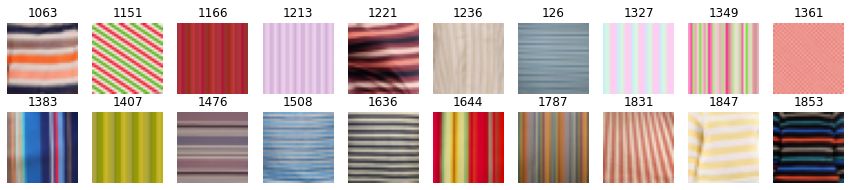

Noisy dataset (3.92% noise):
size: 56400


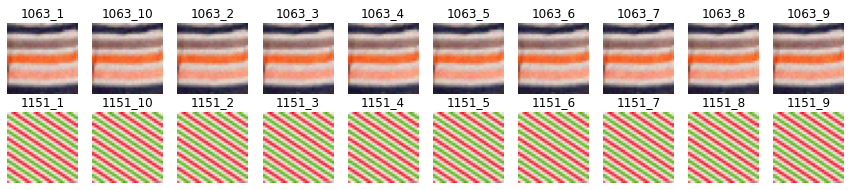

Saving confidence and ood scores to file ./checkpoints/intermediate_results/CIFAR10/scores/Textures_gen_amp_10.csv.
         index       n_1       n_2       n_3       n_4       n_5       n_6  \
0       1063_1  4.170656 -1.232850 -1.183958 -1.343986 -0.777705 -2.730526   
1      1063_10  3.666167 -1.148338 -1.215607 -1.146298 -1.620553 -2.301968   
2       1063_2  3.642386 -1.003898 -1.209949 -1.310654 -1.782897 -2.215007   
3       1063_3  3.944792 -1.582327 -0.752230 -1.468281 -0.533640 -2.509461   
4       1063_4  3.890703 -1.462312 -1.660056 -1.539244 -1.110568 -2.382735   
...        ...       ...       ...       ...       ...       ...       ...   
56395    913_5  2.138791 -4.203161  3.485169  2.076808 -0.549386 -4.382083   
56396    913_6  2.881167 -4.223192  6.201221  1.700743 -0.157578 -4.553039   
56397    913_7  1.211493 -4.309390  2.803720  1.453366 -0.349689 -4.327722   
56398    913_8  1.964154 -4.048965  5.405138  1.023470  0.104796 -4.444795   
56399    913_9  3.786927 -

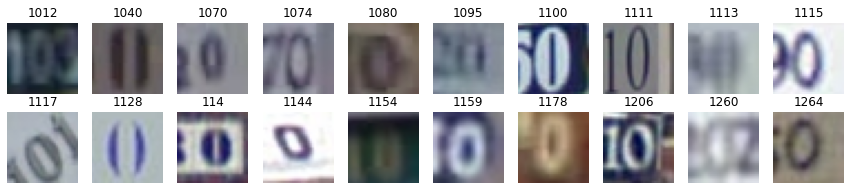

Noisy dataset (3.92% noise):
size: 100000


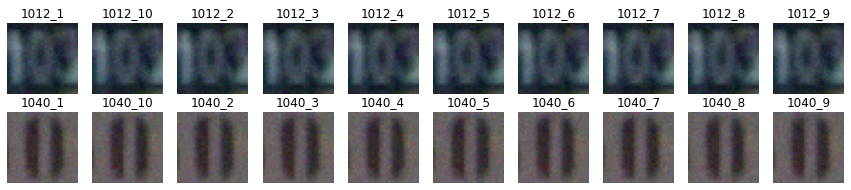

Saving confidence and ood scores to file ./checkpoints/intermediate_results/CIFAR10/scores/SVHN_gen_amp_10.csv.
         index       n_1       n_2       n_3       n_4       n_5       n_6  \
0       1012_1 -4.271617 -3.780580  8.413869  6.537858 -0.791169 -3.017747   
1      1012_10 -2.821989 -3.247307  7.924367  4.849486 -0.269079 -2.850973   
2       1012_2 -5.881966 -4.158069  6.947150  9.463843 -0.268533 -3.871306   
3       1012_3 -4.680601 -3.914671  6.729326  7.217979  0.517910 -2.843445   
4       1012_4 -5.817587 -4.776869  8.957594  9.624661 -0.038771 -4.078093   
...        ...       ...       ...       ...       ...       ...       ...   
99995   9999_5 -4.684607 -4.778007  9.099961  9.179624 -0.242604  0.751880   
99996   9999_6 -3.818240 -4.665696  7.645038  8.547290 -0.639086  1.647238   
99997   9999_7 -3.994793 -4.494793  6.960725  4.800315  0.370229  3.496650   
99998   9999_8 -3.437805 -4.353799  7.775173  7.739771 -0.318829  2.489603   
99999   9999_9 -3.913660 -4.30

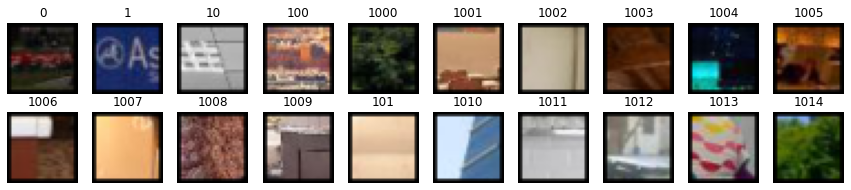

Noisy dataset (3.92% noise):
size: 100000


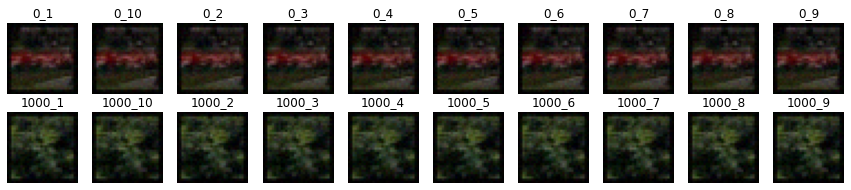

Saving confidence and ood scores to file ./checkpoints/intermediate_results/CIFAR10/scores/LSUN-C_gen_amp_10.csv.
      index       n_1       n_2       n_3       n_4       n_5       n_6  \
0       0_1 -1.261704 -0.825004  1.790126  0.253300  3.888862 -1.845397   
1      0_10 -2.468652 -0.962749  1.022832  0.983255  5.450432 -1.812602   
2       0_2 -2.727982 -0.766320  0.518203  0.183038  4.227516 -1.054309   
3       0_3 -2.440367 -0.444305  0.909973  0.570346  3.909540 -1.380161   
4       0_4 -1.841985 -1.654513  0.992818  0.585832  6.775102 -1.846143   
...     ...       ...       ...       ...       ...       ...       ...   
99995   9_5 -1.660883 -1.452437 -1.208605  1.527269  3.553053 -0.425544   
99996   9_6 -1.675759 -1.849321 -1.057901  1.491410  3.942075 -0.375569   
99997   9_7 -2.219345 -1.518189 -0.826521  1.360559  4.820530 -0.275774   
99998   9_8 -1.727905 -2.611656 -0.623010  1.525888  6.153731 -0.856490   
99999   9_9 -1.778406 -2.047148 -0.029905  2.515205  4.667861

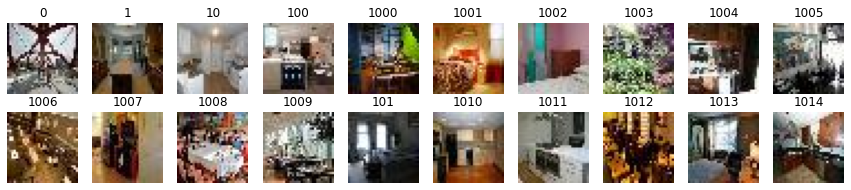

Noisy dataset (3.92% noise):
size: 100000


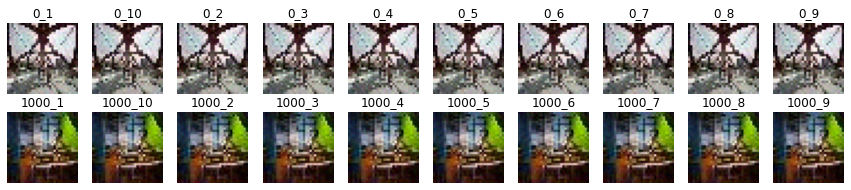

Saving confidence and ood scores to file ./checkpoints/intermediate_results/CIFAR10/scores/LSUN-R_gen_amp_10.csv.
      index       n_1       n_2       n_3       n_4       n_5       n_6  \
0       0_1  1.363378 -1.969160  7.448116  1.393760  1.486317 -2.944901   
1      0_10  1.827491 -1.891654  7.224904  0.907419  1.406525 -2.727032   
2       0_2  1.841002 -2.014783  7.894435  1.133906  0.955135 -2.652191   
3       0_3  1.360412 -1.927801  7.841498  1.721440  1.314729 -2.569052   
4       0_4  1.627402 -2.200460  8.185913  0.881097  1.282399 -2.955622   
...     ...       ...       ...       ...       ...       ...       ...   
99995   9_5 -1.771239 -3.492871  7.052051  6.315049 -1.152559 -2.032125   
99996   9_6 -1.537587 -3.901771  8.203390  6.024697 -1.310471 -2.471050   
99997   9_7 -1.403715 -4.062609  9.166001  7.071503 -0.184839 -0.863734   
99998   9_8 -0.924498 -4.087231  9.912037  5.242397 -1.258777 -1.452171   
99999   9_9 -1.887738 -4.166528  9.789125  6.409902 -1.008061

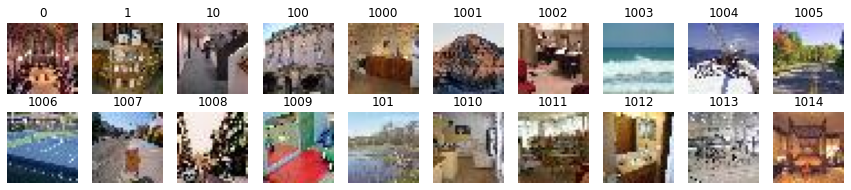

Noisy dataset (3.92% noise):
size: 89250


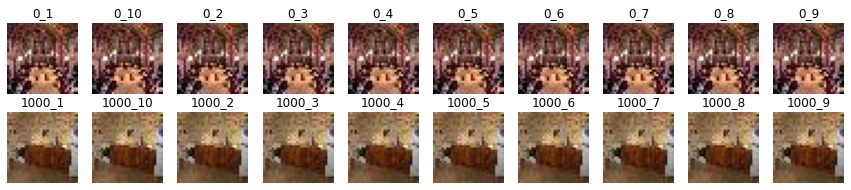

Saving confidence and ood scores to file ./checkpoints/intermediate_results/CIFAR10/scores/iSUN_gen_amp_10.csv.
      index       n_1       n_2       n_3       n_4       n_5       n_6  \
0       0_1 -3.932473 -2.899086  0.234636 -1.333383  1.397848 -2.608487   
1      0_10 -3.975281 -2.818864  0.289103 -1.167866  1.878832 -2.879187   
2       0_2 -3.925066 -2.800084  0.054906 -1.134653  1.746884 -2.879230   
3       0_3 -3.765062 -2.819320  0.257909 -1.145044  1.739454 -2.802733   
4       0_4 -3.932430 -2.755742  0.215036 -1.172293  1.572396 -2.785595   
...     ...       ...       ...       ...       ...       ...       ...   
89245   9_5 -2.666336 -2.458694  5.798040  0.449896  3.191314 -3.488544   
89246   9_6 -2.763638 -2.236379  3.662122  0.260700  2.931498 -3.219965   
89247   9_7 -2.690975 -2.562595  6.109522  1.622996  3.990734 -3.694932   
89248   9_8 -2.809151 -2.236183  6.574804  1.463509  3.206725 -3.788535   
89249   9_9 -3.018267 -2.263079  5.168071  0.769378  3.400400 -

Noisy dataset (3.92% noise):
size: 100000


Saving confidence and ood scores to file ./checkpoints/intermediate_results/CIFAR10/scores/Places365_gen_amp_10.csv.
         index       n_1       n_2       n_3       n_4       n_5       n_6  \
0       1162_1  8.689302 -1.818204  0.428355 -0.890656  0.589950 -3.280972   
1      1162_10  8.206157 -2.064549  0.988011 -1.169587  1.214588 -3.384372   
2       1162_2  8.338951 -2.211561  2.361179 -1.276748  1.026672 -3.525903   
3       1162_3  8.664725 -1.979688  1.477328 -1.452028  1.362206 -3.531182   
4       1162_4  8.886221 -1.863128  0.845160 -1.364791  0.279738 -3.419547   
...        ...       ...       ...       ...       ...       ...       ...   
99995   9576_5 -3.942342 -1.624401  1.350361  0.873157  2.708409 -2.226049   
99996   9576_6 -4.117946 -1.407903  2.035064  0.918948  4.254030 -2.129220   
99997   9576_7 -4.471902 -1.266734  1.766836  0.662275  4.743999 -2.331246   
99998   9576_8 -4.339396 -0.989119  1.112021  0.672083  5.378067 -2.301669   
99999   9576_9 -4.171309 

In [8]:
benchmark = "CIFAR10"
ood_dataset_list = ["Textures", "SVHN", "LSUN-C", "LSUN-R", "iSUN", "Places365"] 
score_functions = ["odin", "energy", "gradnorm"]
amplitudes = [10] # 2,4,6,8,10
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)
logger = logging.getLogger()

folder_path = './checkpoints/intermediate_results/CIFAR10/scores/'

for temp_distribution, dataset_list in {'id': [benchmark], 'ood': ood_dataset_list}.items(): 
    for dataset_name in dataset_list:
        args = {'benchmark': benchmark, 'preprocess': {'mean': [0.492, 0.482, 0.446], 'std': [0.247, 0.244, 0.262], 
                                        'input_size': 32, 'batch_size': 20, 'workers': 8}, 
                'model': {'name': 'wrn', 'depth': 40, 'widden_factor': 2, 'droprate': 0.3, 
                        'path': 'checkpoints/'+benchmark.lower()+'_wrn_normal_standard_epoch_199.pt'}, 
                'data': {'id': {'name': benchmark, 'folder': 'dataset/id_data/'}, 
                         'ood': {'name': ood_dataset_list, 'folder': 'dataset/ood_data/'}}, 
                'sampling' : {'temp_distribution': temp_distribution,
                                'temp_name' : dataset_name,
                                'n_temp' : 'all',
                                'n_gen' : 10,
                                'method' : {'name' : 'uniform', 'a' : 1},
                                'save_path' : 'dataset/' + temp_distribution + '_' + dataset_name + '_noisy_data/'},
                'scores': {'msp': {'T': 1.0}, 'odin': {'T': 1000, 'epsilon': 0.0014}, 'energy': {'T': 1.0}, 'gradnorm': {'T': 1.0}},
                'eval': {'pos': 'id', 'num_ood': 2000, 'num_to_avg': 5}, 'seed': 1, 'logdir': 'checkpoints/test_log'}

        args = HierarchicalDict(args)

        # Load template dataset
        temp_set, temp_loader = load_dataset_from_folder(args.sampling.save_path, 
                                                            args.sampling.temp_name.replace('-', '_')+'_temp', 
                                                            args, shuffle=False)
        temp_set_raw, temp_loader_raw = load_dataset_from_folder(args.sampling.save_path, 
                                                                    args.sampling.temp_name.replace('-', '_')+'_temp', 
                                                                    args, shuffle=False, raw=True)
        print(temp_distribution.upper(), "Dataset:", dataset_name)
        print("Clean dataset:")
        print("size:", len(temp_set_raw))

        # Plot some template images
        show_images(temp_set_raw)

        # Load model
        model = build_model(args, 10, device)

        # # Calculate confidence scores, model predictions and OoD scores.
        # filename_temp = dataset_name+'_temp.csv'
        # cal_conf_ood_scores(model, temp_set, temp_loader, folder_path, filename_temp, args, device=device)
        
        for amp in amplitudes:
            # Load noisy dataset
            noisy_set, noisy_loader = load_dataset_from_folder(args.sampling.save_path, 
                                                                    args.sampling.temp_name.replace('-', '_')
                                                                    +'_gen_amp_' + str(amp), 
                                                                    args, shuffle=False)
            noisy_set_raw, noisy_loader_raw = load_dataset_from_folder(args.sampling.save_path, 
                                                                    args.sampling.temp_name.replace('-', '_')
                                                                    +'_gen_amp_' + str(amp), 
                                                                    args, shuffle=False, raw=True)
            print(f"Noisy dataset ({round(amp/255*100, ndigits=2)}% noise):")
            print("size:", len(noisy_set_raw))

            # Plot some corrupted images
            show_images(noisy_set_raw)

            # Calculate confidence scores, model predictions and OoD scores.
            filename_gen = dataset_name + '_gen_amp_' + str(amp) + '.csv'
            cal_conf_ood_scores(model, noisy_set, noisy_loader, folder_path, filename_gen, args, device=device)
            